```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Classify and view results

In [1]:
import os
import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import skimage.morphology as morphology
os.environ['KERAS_BACKEND'] = 'tensorflow'
import classifier
import imageio
from skimage.filters import gaussian
from skimage import measure
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# Enable interactive plots
%matplotlib notebook

## First generate your F3 block slice and export as csv file in opendtect
- Survey -> Export -> Seismic -> Simple File -> 3D
- Select "1 Original Seismics" as Input Cube
- Choose a volume subsection, (our was inline:244~244, crossline:300~1250, z-slice:0~1848) to get inline #244
- **Output a position for every trace:** no
- **Put sampling info in file start:** no
- **File type:** ASCII
- **Output file:** slice.csv

## Define a seismic name

In [3]:
seismic_name = "f3"

## Format csv file

In [4]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [5]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [6]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

<IPython.core.display.Javascript object>


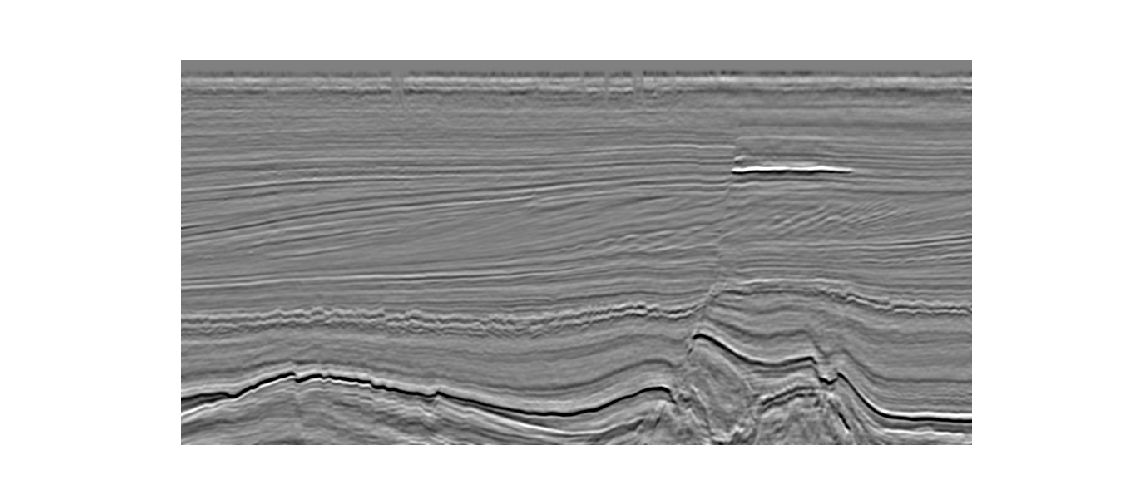

In [7]:
# Set configurations for format subvolume
data_file = 'data/f3_inl_244.csv'
min_inl = 244
max_inl = 244
step_inl = 1
min_crl = 300
max_crl = 1250
step_crl = 1
min_z = 0
max_z = 1848
step_z = 4

output_dir = 'data/formatted/'+seismic_name+'/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

# Define sections type
types=['inline','crossline','z-slice','section_coords']
section_type = 'inline'
    
# Read and format files
raw_data = np.genfromtxt(data_file, delimiter='\t')

if(section_type == "inline"):
    nb_crosslines = (max_crl - min_crl) / step_crl + 1
    
if(section_type == "crossline"):
    nb_crosslines = (max_inl - min_inl) / step_inl + 1
    
nb_sections = raw_data.shape[0]/nb_crosslines

for k in range(int(nb_sections)):
    # Output name
    if(section_type == "inline"):
        inl_nb = int(min_inl + k);
        name = 'inl'+str(inl_nb)+'_sc_formatted.csv'
    if(section_type == "crossline"):
        crl_nb = int(min_crl + k);
        name = 'crl'+str(crl_nb)+'_sc_formatted.csv'

    # Read
    section = raw_data[k*int(nb_crosslines) : (k+1)*int(nb_crosslines), : ]
    section = np.transpose(section)
    
    # Smooth
    section = myGaussSmooth(section)

    # Clip
    section = clip(section)

    # Normalize between -1 and 1 
    section = myNormalization(section)

    # Write
    np.savetxt(output_dir + name, section, delimiter=" ")
    
    # Visualize
    plt.figure(figsize=(9,4))
    plt.axis('off')
    plt.imshow(section, cmap="gray")

<IPython.core.display.Javascript object>


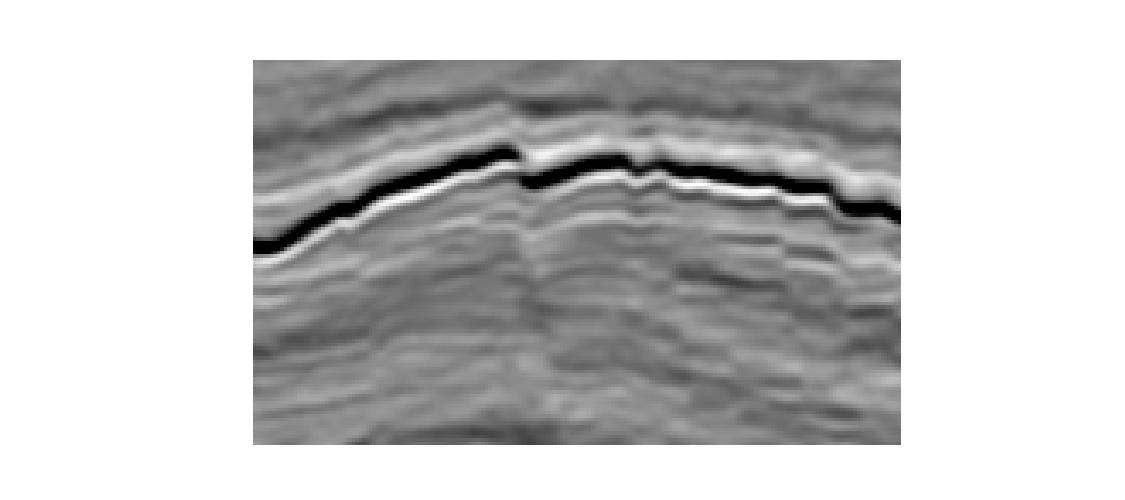

In [9]:
# read and convert coords for clipping to ROI
if(section_type == "inline"):
    x1 = 359 # crl init
    x2 = 549 # crl end
    y1 = 1400 # z init
    y2 = 1848 # z end
    init_data_x = 300 # cube data crl init
    init_data_y = min_z
    x_step = step_inl
    y_step = step_z # z_step

if(section_type == "crossline"):
    #No Crop. Change values if crop is desired
    x1 = min_inl # inl init
    x2 = max_inl # inl end
    y1 = min_z # z init
    y2 = max_z # z end
    init_data_x = min_crl # cube data crl init
    init_data_y = min_z # cube data crl init
    x_step = step_crl
    y_step = step_z # z_step
    ## TODO : zline sections
    
x1Idx = int((x1 - init_data_x) / x_step)
x2Idx = int((x2 - init_data_x) / x_step)
y1Idx = int((y1-init_data_y) / y_step)
y2Idx = int((y2-init_data_y) / y_step + 1)

# Set directories
input_dir = 'data/formatted/'+seismic_name+'/'
output_dir = 'output/sections_regions/'+seismic_name+'/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 


# cut regions
files = os.listdir(input_dir)
for i in range(0, len(files)):
    # open section
    filename = files[i]
    formatted_section = np.genfromtxt(input_dir + filename, delimiter=' ')

    # extraction        
    piece = formatted_section[y1Idx:y2Idx,x1Idx:x2Idx]

    # save
    out_filename = filename.split('.')[0] + "_region_(" + str(x1) + "." + str(y1) + ")(" + str(x2) + "." + str(y2) + ").csv"
    np.savetxt(output_dir + out_filename, piece, delimiter=" ")
    
    # Visualize
    plt.figure(figsize=(9,4))
    plt.axis('off')
    plt.imshow(piece, cmap="gray", vmin=-1, vmax=1)

## Generate classification files to each method

In [10]:
input_dir = 'output/sections_regions/'+seismic_name+'/'

patch_size_VGG = 5
patch_size = 20
pixel_step = 1

vggModel = 'models/vgg.json'
vggWeights = 'models/vgg.h5'
mlpModel = 'models/mlp.json'
mlpWeights = 'models/mlp.h5'
fftModel = 'models/fft.json'
fftWeights = 'models/fft.h5'
svmModel = 'models/modelSVM.pkl'

### **VGG**: Classification based on the proposed method presented in the first article

In [11]:
classifier.classify(input_dir, patch_size_VGG, pixel_step, vggModel, vggWeights, 'VGG')

Creating patches...
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Pickling array (shape=(190,), dtype=int64).
Pickling array (shape=(190, 113), dtype=float64).
Pickling array (shape=(190,), dtype=int64).
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   14.0s finished
Classifying section 1/1
Writing classification files...
Section VGG_inl244
--- 23.86355423927307 seconds ---


### **MLP**: Multi Layer Perceptron architecture presented in the article of this example

In [12]:
classifier.classify(input_dir, patch_size, pixel_step, mlpModel, mlpWeights, 'MLP')

Creating patches...
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Pickling array (shape=(190,), dtype=int64).
Pickling array (shape=(190, 113), dtype=float64).
Pickling array (shape=(190,), dtype=int64).
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:   22.9s
[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   22.9s finished
Classifying section 1/1
Writing classification files...
Section MLP_inl244
--- 31.41002321243286 seconds ---


### **FFT**: Full Fine Tunning architecture presented in the article of this example

In [13]:
classifier.classify(input_dir, patch_size, pixel_step, fftModel, fftWeights, 'FFT')

Creating patches...
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Pickling array (shape=(190,), dtype=int64).
Pickling array (shape=(190, 113), dtype=float64).
Pickling array (shape=(190,), dtype=int64).
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:   22.7s
[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   22.8s finished
Classifying section 1/1
Writing classification files...
Section FFT_inl244
--- 30.957576990127563 seconds ---


### **SVM**: Support Vector Machine architecture presented in the article of this example

In [14]:
classifier.classifySVM(input_dir, patch_size, pixel_step, vggModel, vggWeights, 'SVM', svmModel)

Creating patches...
[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
Pickling array (shape=(190,), dtype=int64).
Pickling array (shape=(190, 113), dtype=float64).
Pickling array (shape=(190,), dtype=int64).
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:   23.1s
[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   23.1s finished
Classifying section 1/1
Writing classification files...
Section SVM_inl244
--- 136.97381234169006 seconds ---


## Create colormap

In [15]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Vizualize Slice and Classified Mask

<IPython.core.display.Javascript object>


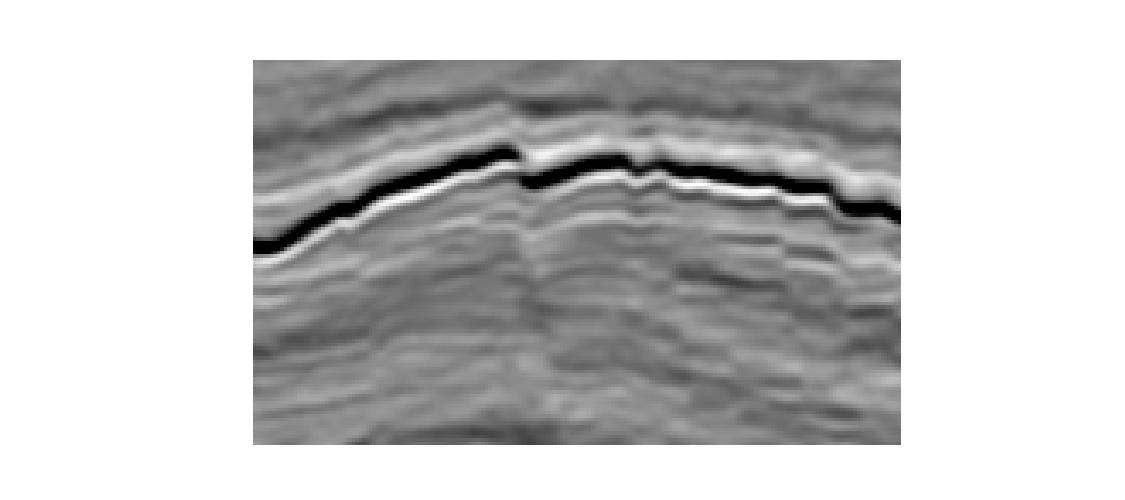

In [19]:
section_file = 'output/sections_regions/f3/inl244_sc_formatted_region_(359.1400)(549.1848).csv'
section_name = section_file.split('/')[3].split('_')[0]

my_data = np.genfromtxt(section_file, delimiter=' ')
plt.figure(figsize=(9,4))
plt.axis('off')
plt.imshow(my_data, cmap="gray")

<IPython.core.display.Javascript object>


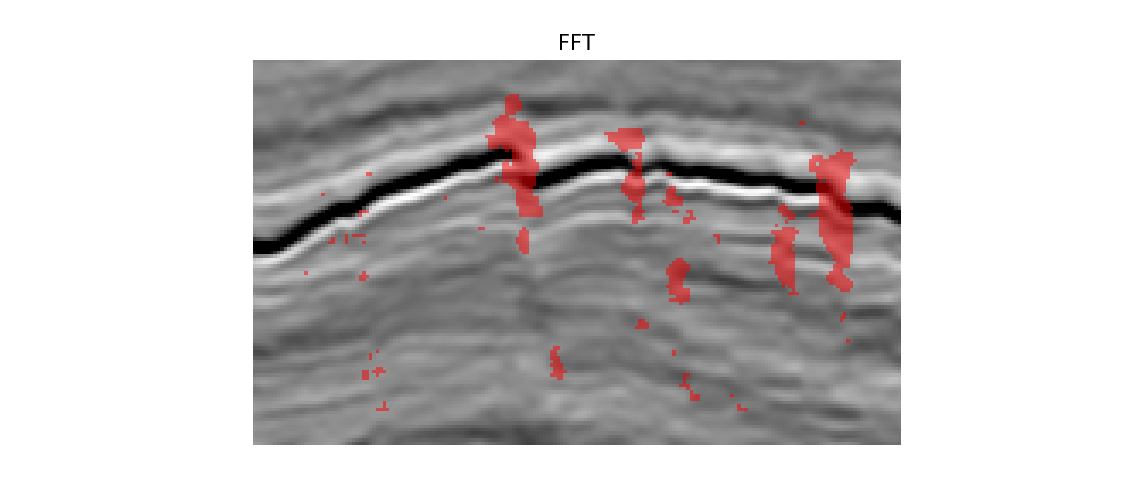

<IPython.core.display.Javascript object>


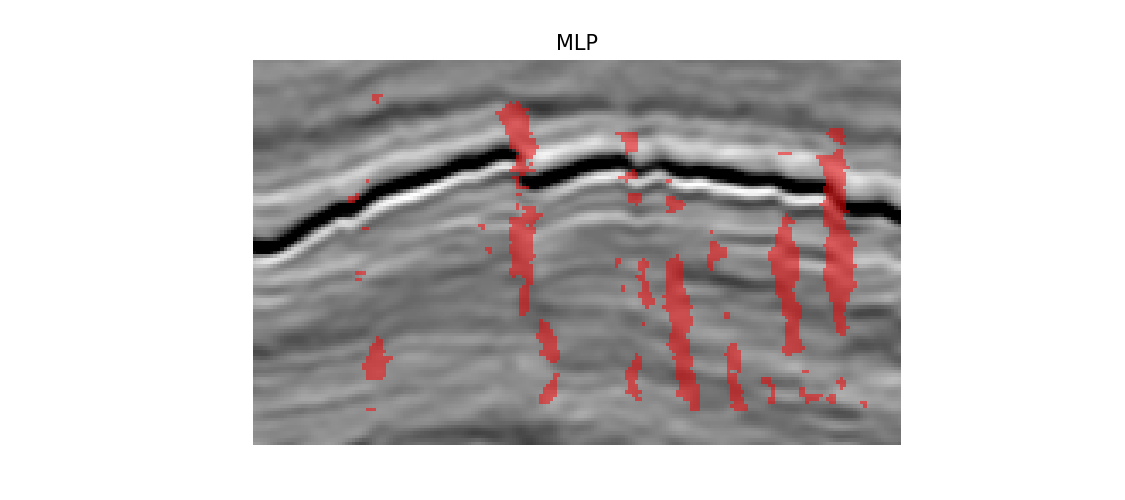

<IPython.core.display.Javascript object>


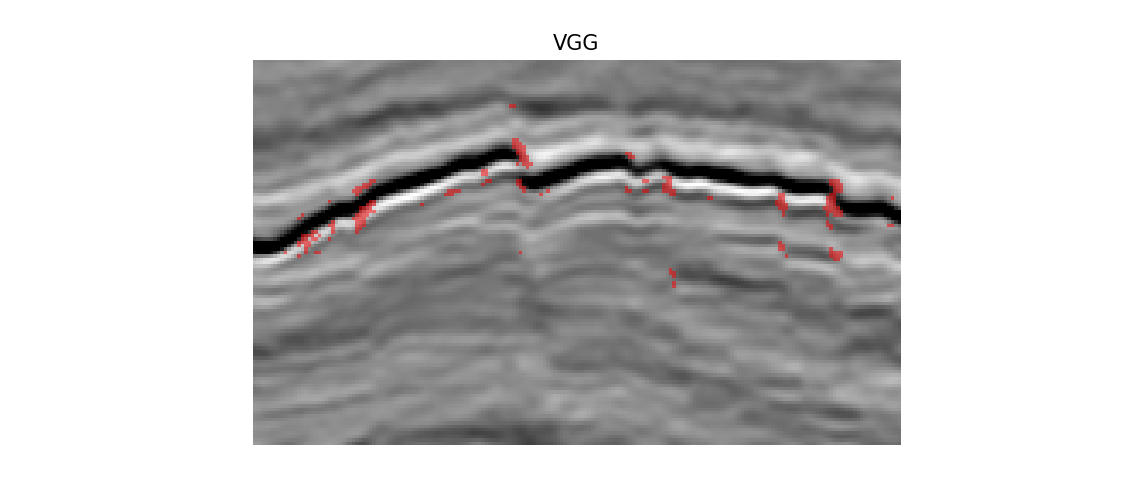

<IPython.core.display.Javascript object>


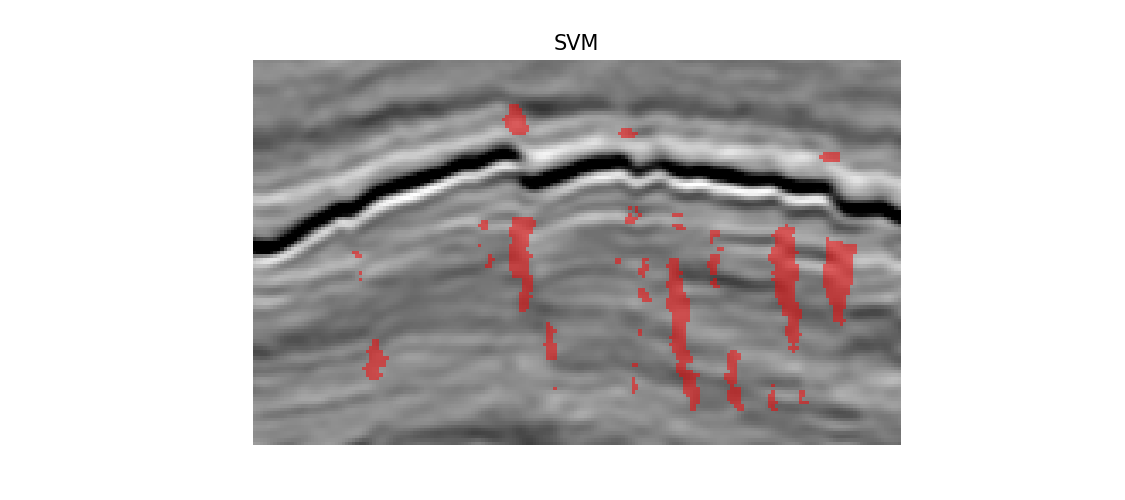

In [21]:
classification_files = {}
classification_files['VGG'] = 'output/classification/classification_VGG_inl244.txt'
classification_files['MLP'] = 'output/classification/classification_MLP_inl244.txt'
classification_files['FFT'] = 'output/classification/classification_FFT_inl244.txt'
classification_files['SVM'] = 'output/classification/classification_SVM_inl244.txt'

for model, file in classification_files.items():
    mask = np.zeros(my_data.shape)
    classification = open(file, 'r')
    for line in classification:
        if int(line.split()[1]) == 1:
            patch = line.split()[0]
            x = int(patch.split("_")[2])
            y = int(patch.split("_")[3].split(".")[0])
            mask[x,y] = 1

    plt.figure(figsize=(9,4))
    plt.title(model)
    plt.axis('off')
    plt.imshow(my_data, cmap="gray")
    plt.imshow(mask, cmap="faults")
    plt.savefig('result'+model+'_'+section_name+'.png',dpi=300)